In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import signal
from scipy.io import wavfile
import io
from PIL import Image
import librosa

test_file = '/home/george-vengrovski/Documents/canary_attention/canary_data/llb3_0007_2018_04_23_14_19_29.wav'
root = '/home/george-vengrovski/Documents/canary_attention'

#### For tuning parameters on a test file, and defining several functions

In [11]:
# create sonogram of the whole song 
 
# wav to numpy array
def wav_to_numpy(file):
    rate, data = wavfile.read(file)
    return rate, data

def createSonogram(songfile):
    data = wav_to_numpy(songfile)
    rate = data[0]
    data = data[1]

    f, t, Sxx = signal.spectrogram(data, rate, nfft=512, noverlap=25, scaling="density")

    fmin = 400 # Hz
    fmax = 8000 # Hz
    freq_slice = np.where((f >= fmin) & (f <= fmax))

    # keep only frequencies of interest
    f   = f[freq_slice]
    Sxx = Sxx[freq_slice,:][0]

    Sxx = np.log(Sxx + 1)

    np_sonogram = np.array(Sxx, dtype="float32")
    # figure size in inches 1,1
    # plt.figure(figsize=(300,5))

    # plt.pcolormesh(Sxx)
    # plt.axis('off')
    return plt, np_sonogram 

# np sonogram is the numpy array of the sonogram
plt, np_sonogram = createSonogram(test_file)

print(np_sonogram.shape)
print(librosa.get_duration(filename=test_file) * 1000)

ms_per_x_pixels = (librosa.get_duration(filename=test_file) * 1000) / np_sonogram.shape[1]
print(ms_per_x_pixels)

(88, 1012)
5304.149659863945
5.241254604608641


/tmp/ipykernel_30988/897989053.py:38: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  print(librosa.get_duration(filename=test_file) * 1000)
/tmp/ipykernel_30988/897989053.py:40: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  ms_per_x_pixels = (librosa.get_duration(filename=test_file) * 1000) / np_sonogram.shape[1]


<Figure size 640x480 with 0 Axes>

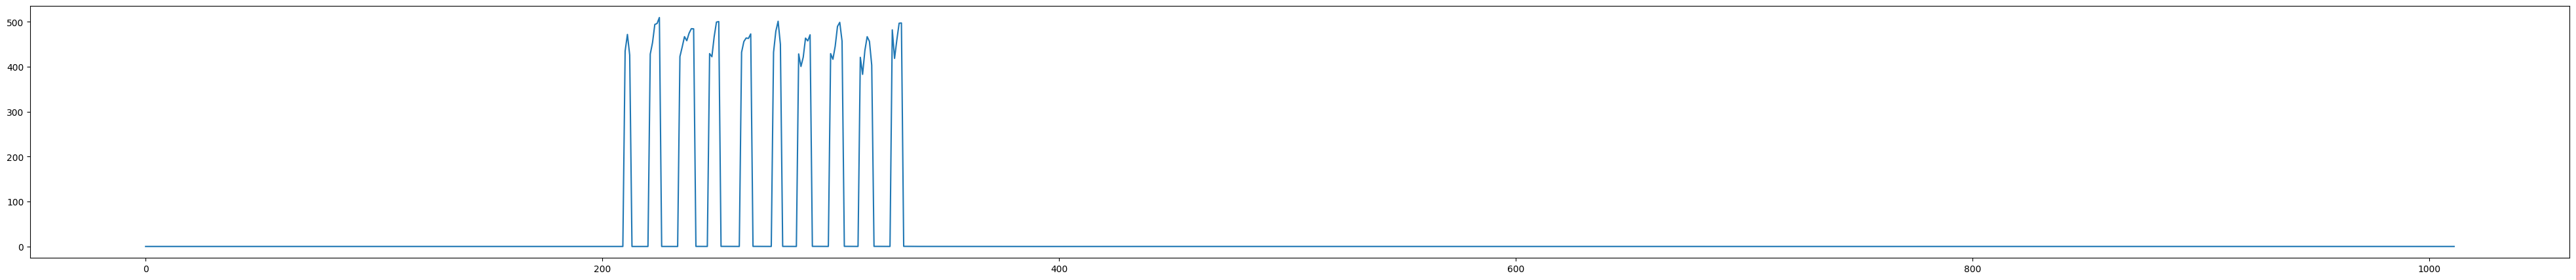

In [14]:
# reverse the axis of the np array dim1 becomes dim 0 and vice versa
np_sonogram = np_sonogram.T

vertical_sum = np.sum(np_sonogram, axis=1)
# x axis is the time axis
# figure dims the same as below
plt.figure(figsize=(50,5))
plt.plot(vertical_sum) 

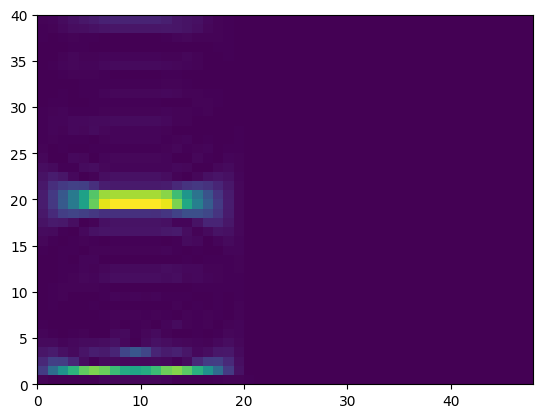

In [15]:
f, t, Sxx = signal.spectrogram(vertical_sum, 1, nfft=256, noverlap=240, scaling="density")
Sxx = Sxx[:40]

plt.pcolormesh(Sxx)

# limit vertical sum to first 1k values
vertical_sum = vertical_sum[:1000]

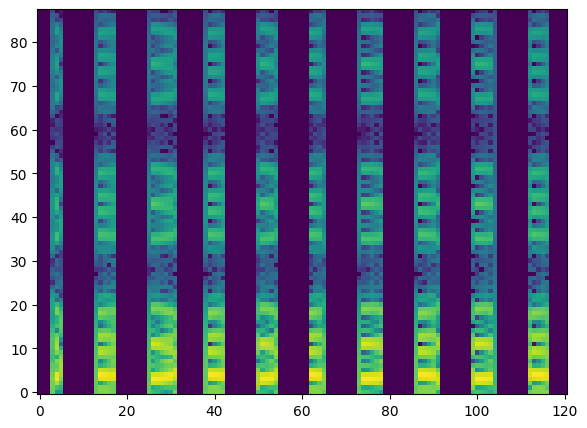

In [16]:
from matplotlib.pyplot import axis 

window_size = 8
threshold = 3

# window slides over vertical sum, takes the average and keeps it if it is above threshold
def sliding_window_average(vertical_sum, window_size, threshold):
    window = np.ones(int(window_size))/float(window_size)
    y = np.convolve(vertical_sum, window, 'same')
    y = np.where(y > threshold, y, 0)
    return y

y = sliding_window_average(vertical_sum, window_size, threshold)

# get the indices of the locations where the vertical sum is above threshold
indices = np.where(y > 0)[0]
plt.figure(figsize=(50,5))
plt.imshow(np_sonogram[indices].T, origin='lower')

#### Segment generator 

In [8]:
import math 
import matplotlib
import gc
from matplotlib import pyplot as plt
import random

window_size = 8
threshold = 7

precent_skipped = 0

files = '/home/george-vengrovski/Documents/canary_attention/canary_data'

def create_segments(sonogram):
    # 120ms
    window_length = 5
    # 90 precent overlap 
    window_overlap = .7

    # step size is equal to the amount of pixels the frame needs to move
    # this is equal to the frame size multiplied by the overlap
    # the frame size needs to be adjusted to the amount of pixels per ms
    step_size = int(window_length * (1 - window_overlap))
    start_frame = 0
    end_frame = int(window_length)
    
    positions = []

    sonogram = np.swapaxes(sonogram, 0, 1)

    while end_frame < sonogram.shape[0]:
        if random.random() > precent_skipped:
            positions.append([start_frame, end_frame])
        start_frame += step_size
        end_frame += step_size
    return positions

save_dir = '/home/george/Documents/george_vae/testing/UMAP_Over_Time_Y11'
root_dir = '/home/george/Documents/data/Y11/'

for folder in os.listdir(root_dir):
    list_of_np_sonograms = []
    for file in os.listdir(root_dir + folder):
        # delete all the files in the after folder
        try:
            filename = file 
            file = root_dir + folder + '/' + file
            plt, np_sonogram = createSonogram(file)
            np_sonogram = np_sonogram.T
            vertical_sum = np.sum(np_sonogram, axis=1)
            y = sliding_window_average(vertical_sum, window_size, threshold)
            indices = np.where(y > 0)[0]
            list_of_np_sonograms.append(np_sonogram[indices].T)
            

        except:
            print('error with file: ', file)

    list_of_positions = []
    for sonograms in list_of_np_sonograms:
        list_of_positions.append(create_segments(sonograms))

    os.mkdir(save_dir + '/' + folder)

    for i, sonogram in enumerate(list_of_np_sonograms):
        sonogram = np.swapaxes(sonogram, 0, 1)
        for j, position in enumerate(list_of_positions[i]):
            segment = sonogram[position[0]:position[1]]
            segment = segment.T
            # flip the segment upside down
            segment = np.flip(segment, axis=0)
            plt.figure(figsize=(1.28,1.28))
            plt.imshow(segment, aspect='auto')
            plt.gca().set_axis_off()
            plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                        hspace = 0, wspace = 0)
            plt.margins(0,0)
            plt.savefig(save_dir + '/' + folder + '/test' + 'file:' + str(i) + '_segment:' + str(j) + '.png', dpi=100)
            plt.clf()

FileNotFoundError: [Errno 2] No such file or directory: '/home/george/Documents/data/Y11/'